In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude ,calcualteBumpAmplitude_V2_green, calculateBumpWidth_v1

In [3]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/EPG_EB(syt)/cl')
count = 0
output_df_pooled = pd.DataFrame()
output_bump_amplitude_pooled = pd.DataFrame()
output_bump_amplitude_V2_pooled = pd.DataFrame()
output_bump_width_pooled = pd.DataFrame()
output_PVA_strength_pooled = pd.DataFrame()
for single_df in os.listdir(pooled_directory):
    current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
    #Get time info
    volume_cycle = len(current_file )
    volume_time = current_file['Time_Stamp'][1]
    volume_rate = 1/volume_time
    time_array_imaging = np.arange(volume_cycle)/volume_rate
    #Get necessary parameters
    PVA_Unwrapped_Radian = current_file['Unwrapped_Radian']
    PVA_Angle = current_file['PVA_Angle']
    Angular_velocity = current_file['Angular_Velocity']
    integrated_x = current_file['Integrated_x']
    PVA_strength = current_file['PVA_strength']
    Bump_amplitude = current_file['Bump_amplitude']
    Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading']
    
    dff_normalized_8_roi = np.zeros((len(current_file['dFF_Roi_1']), 8))
    for i in range(len(current_file['F_Roi_1'])):
        dff_normalized_8_roi[i,0]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi[i,1]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi[i,2]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi[i,3]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi[i,4]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi[i,5]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi[i,6]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi[i,7]= current_file['dFF_Roi_8'][i]
    
    #Need no series array for function below 
    PVA_Unwrapped_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Angle_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Angular_velocity_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    integrated_x_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_strength_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Bump_amplitude_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Unwrapped_heading_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    for i in range(len(current_file['Unwrapped_Radian'])):
        PVA_Unwrapped_Radian_no_series[i] = current_file['Unwrapped_Radian'][i]
        PVA_Angle[i] = current_file['PVA_Angle'][i]
        PVA_Angle_no_series[i] = current_file['PVA_Angle'][i]
        Angular_velocity_no_series[i] = current_file['Angular_Velocity'][i]
        integrated_x_no_series[i] = current_file['Integrated_x'][i]
        PVA_strength_no_series[i] = current_file['PVA_strength'][i]
        Bump_amplitude_no_series[i] = current_file['Bump_amplitude'][i]
        Unwrapped_heading_no_series[i] = current_file['Unwrapped_Bar_Position/Heading'][i]
    
    integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
    Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
    Forward_speed_radian = np.abs(Forward_velocity)
    Forward_speed_degrees =Forward_speed_radian * 180/np.pi
    
    #Get persistence period
    persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
    #Calculate annd plot difference throughout the stop period
    difference_during_stop = []
    current_difference_during_stop = []
    current_forward_speed_during_stop = []
    forward_speed_during_stop =[]
    #plt.figure(figsize= (25,7))
    for current_index in range(len(persistence_stop_index_and_length)):
        current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
        current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
        current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
        current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
        #Modify the value so angle difference will never be different more than 180 degrees
        for j in range(len(current_difference_during_stop)):
            if np.abs(current_difference_during_stop[j]) > 180:
                if current_difference_during_stop[j] < 0:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                else:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
        difference_during_stop.append(current_difference_during_stop)
        forward_speed_during_stop.append(current_forward_speed_during_stop)
    
    # A different way to calculate bump amplitude
    Bump_amplitude_V2 = calcualteBumpAmplitude_V2_green(dff_normalized_8_roi)
    
    # Bump_width
    Bump_width = calculateBumpWidth_v1(dff_normalized_8_roi, 8)
    
    bump_amplitude_stopping_duration = 10
    minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time))
    #200ms bin size
    bump_amplitude_stopping_bin_size = 0.2
    
    #gaussian smooth the Bump Amplitude/PVA Strength Array as in Fisher, Marquis 2022
    Bump_amplitude_gaussian_smooth = gaussian_filter1d(Bump_amplitude, sigma =3)
    #Bump_amplitude_gaussian_smooth = gaussian_filter1d(np.max(dff_normalized_8_roi,axis=1), sigma =3)
    PVA_strength_gaussian_smooth = gaussian_filter1d(PVA_strength, sigma =3)
    Bump_amplitude_v2_gaussian_smooth = gaussian_filter1d(Bump_amplitude_V2, sigma =3)
    Bump_width_gaussian_smooth = gaussian_filter1d(Bump_width, sigma =3)
    
    stopping_period_PVA_strength_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 10,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =PVA_strength_gaussian_smooth)
    bump_amplitude_stopping_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 10,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =Bump_amplitude_gaussian_smooth)
    bump_amplitude_v2_stopping_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 10,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =Bump_amplitude_v2_gaussian_smooth)
    bump_width_stopping_current = stopping_period_signal_decay(volume_time= volume_time, bump_amplitude_stopping_duration = 10,bump_amplitude_stopping_bin_size = 0.2, minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time)), stopping_array =persistence_stop_index_and_length , signal_array =Bump_width_gaussian_smooth)
    stopping_period_bump_amp_current = pd.DataFrame(bump_amplitude_stopping_current.transpose())
    stopping_period_bump_amp_v2_current = pd.DataFrame(bump_amplitude_v2_stopping_current.transpose())
    stopping_period_bump_width_current = pd.DataFrame(bump_width_stopping_current.transpose())
    stopping_period_PVA_strength_current = pd.DataFrame(stopping_period_PVA_strength_current.transpose())
    if count == 0:
        output_bump_amplitude_pooled = stopping_period_bump_amp_current
        output_PVA_strength_pooled =  stopping_period_PVA_strength_current
        output_bump_amplitude_V2_pooled = stopping_period_bump_amp_v2_current
        output_bump_width_pooled = stopping_period_bump_width_current
    else:
        output_bump_amplitude_pooled = pd.concat([output_bump_amplitude_pooled,stopping_period_bump_amp_current],ignore_index=True, axis =1)
        output_PVA_strength_pooled = pd.concat([output_PVA_strength_pooled,stopping_period_PVA_strength_current],ignore_index=True, axis =1)
        output_bump_amplitude_V2_pooled = pd.concat([output_bump_amplitude_V2_pooled,stopping_period_bump_amp_v2_current],ignore_index=True, axis =1)
        output_bump_width_pooled = pd.concat([output_bump_width_pooled,stopping_period_bump_width_current],ignore_index=True, axis =1)
    
    
    PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
    single_trial_info = single_df.split("-")
    flytrial = [single_trial_info[0], single_trial_info[1]]
    PVA_angle_at_stop.insert(0,'FlyTrial',"-".join(flytrial))
    PVA_angle_at_stop.insert(1,'Genotype','R60D05>GCaMP7f')
    PVA_angle_at_stop.insert(2,'TrialType','dark')
    Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
    Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
    output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
    
    if count == 0:
        output_df_pooled = output_df
    else:
        output_df_pooled = pd.concat([output_df_pooled,output_df], ignore_index=True)
    
    count = count + 1

In [4]:
output_bump_amplitude_pooled_percentage = output_bump_amplitude_pooled.copy()
for i in range(len(output_bump_amplitude_pooled_percentage.mean(axis=0))):
    output_bump_amplitude_pooled_percentage[i] = output_bump_amplitude_pooled_percentage[i]/output_bump_amplitude_pooled_percentage[i][0]

In [5]:
len(output_bump_amplitude_pooled_percentage.mean(axis=0))

107

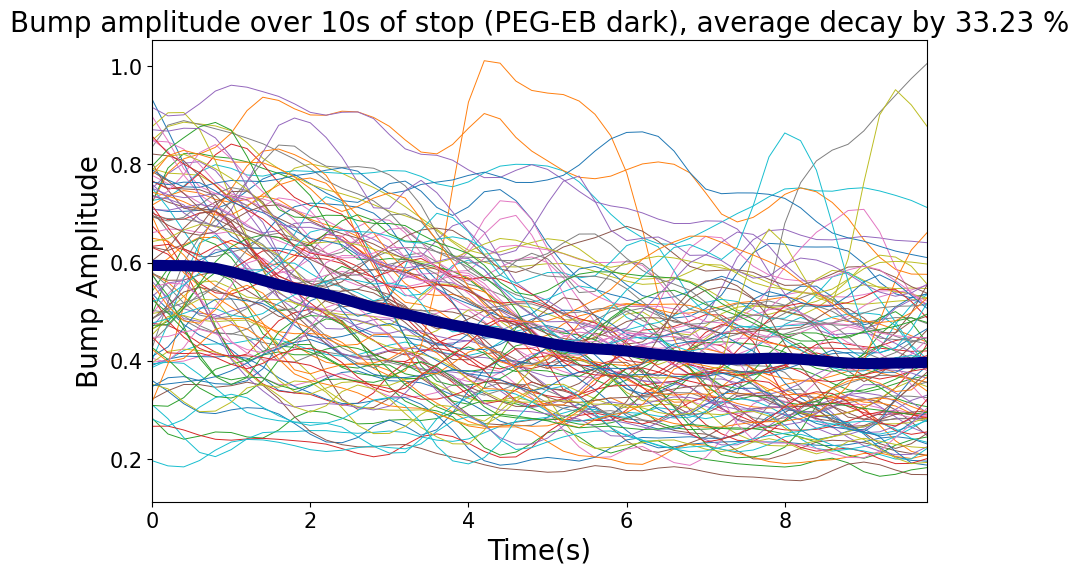

In [6]:
average_decay_Bump_a = round((output_bump_amplitude_pooled.mean(axis=1)[0]-output_bump_amplitude_pooled.mean(axis=1)[49])/output_bump_amplitude_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_amplitude_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_amplitude_pooled.columns)):
    plt.plot(time_array_decay,output_bump_amplitude_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_amplitude_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,9.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude over 10s of stop (PEG-EB dark), average decay by {average_decay_Bump_a} %",fontsize =20)
plt.show()


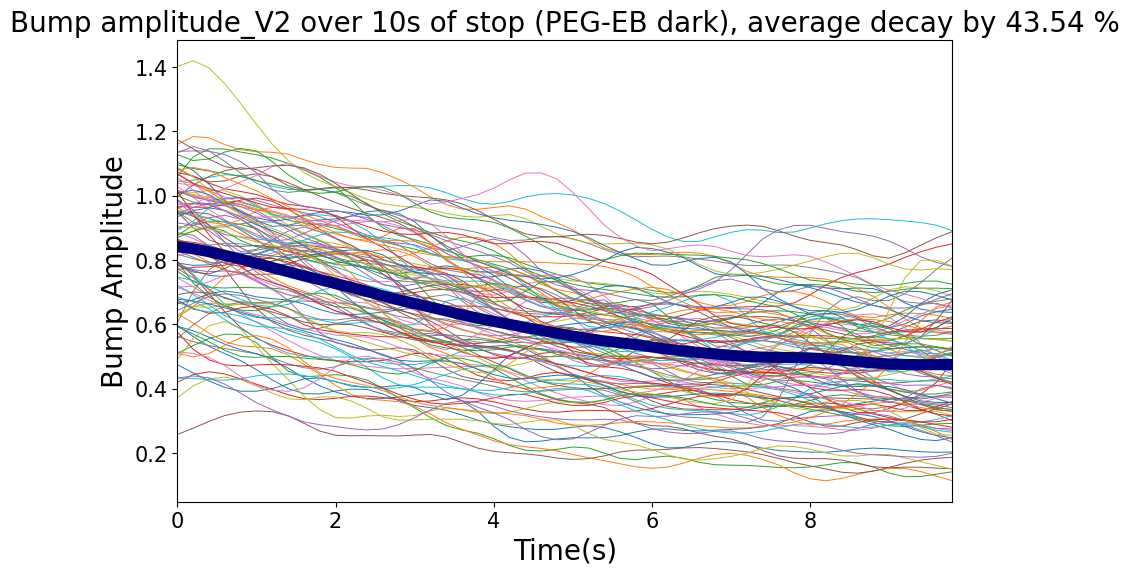

In [7]:
average_decay_Bump_a_V2 = round((output_bump_amplitude_V2_pooled.mean(axis=1)[0]-output_bump_amplitude_V2_pooled.mean(axis=1)[49])/output_bump_amplitude_V2_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_amplitude_V2_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_amplitude_V2_pooled.columns)):
    plt.plot(time_array_decay,output_bump_amplitude_V2_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_amplitude_V2_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,9.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump amplitude_V2 over 10s of stop (PEG-EB dark), average decay by {average_decay_Bump_a_V2} %",fontsize =20)
plt.show()

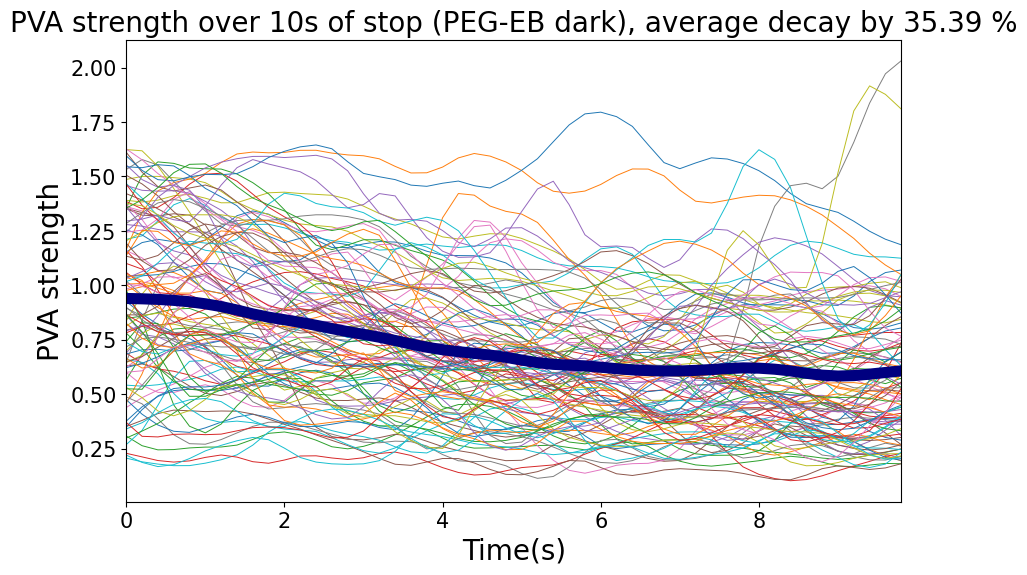

In [8]:
average_decay_PVA_S = round((output_PVA_strength_pooled.mean(axis=1)[0]-output_PVA_strength_pooled.mean(axis=1)[49])/output_PVA_strength_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_PVA_strength_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_PVA_strength_pooled.columns)):
    plt.plot(time_array_decay,output_PVA_strength_pooled[i], linewidth = 0.7)
plt.plot(time_array_decay,output_PVA_strength_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,9.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('PVA strength', fontsize=20)
plt.title(f"PVA strength over 10s of stop (PEG-EB dark), average decay by {average_decay_PVA_S} %",fontsize =20)
plt.show()

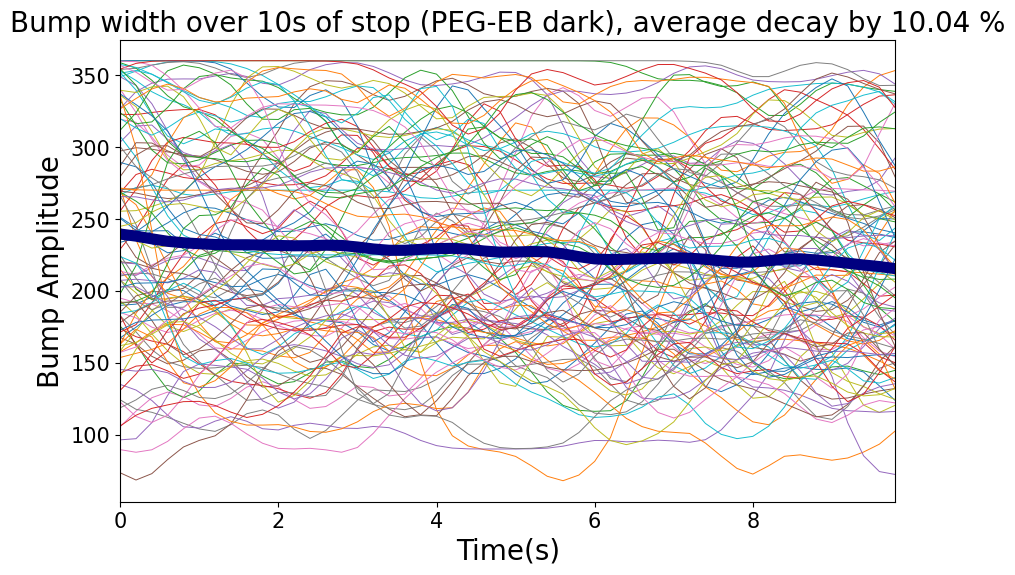

In [9]:
average_decay_Bump_W = round((output_bump_width_pooled.mean(axis=1)[0]-output_bump_width_pooled.mean(axis=1)[49])/output_bump_width_pooled.mean(axis=1)[0]*100,2)
time_array_decay = np.arange(len(output_bump_width_pooled.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_width_pooled.columns)):
    plt.plot(time_array_decay,output_bump_width_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_bump_width_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,9.8)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Bump Amplitude', fontsize=20)
plt.title(f"Bump width over 10s of stop (PEG-EB dark), average decay by {average_decay_Bump_W} %",fontsize =20)
plt.show()

In [78]:
output_bump_width_pooled.mean(axis=1)[0]-output_bump_width_pooled.mean(axis=1)[49]

55.50830219968424

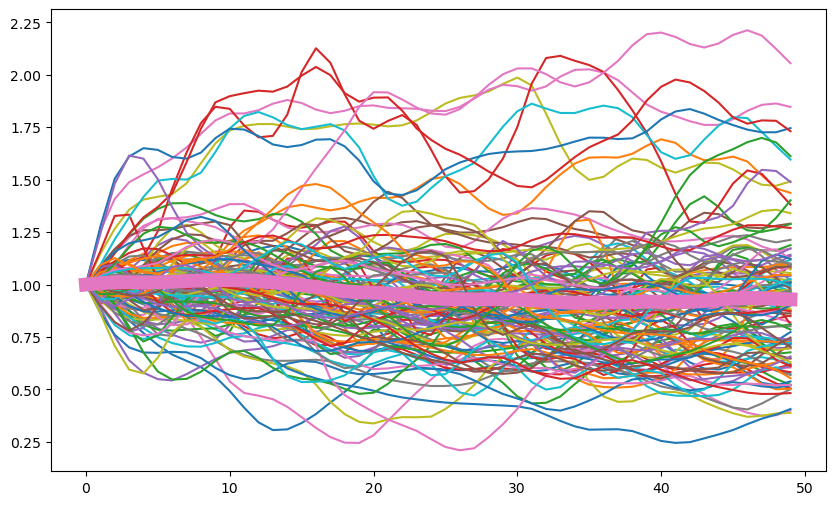

In [79]:
time_array_decay = np.arange(len(output_bump_amplitude_pooled_percentage.mean(axis=1)))/5
plt.figure(figsize=(10,6))
for i in range(len(output_bump_amplitude_pooled_percentage.columns)):
    plt.plot(output_bump_amplitude_pooled_percentage[i])
plt.plot(output_bump_amplitude_pooled_percentage.mean(axis=1), linewidth=10)
plt.show()

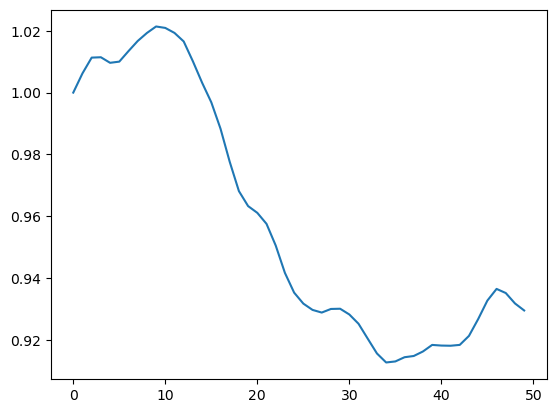

In [80]:
plt.plot(output_bump_amplitude_pooled_percentage.mean(axis=1))
plt.show()

In [15]:
output_df_pooled

,FlyTrial,Genotype,TrialType,Period_duration,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_in_middle,PVA_2s_before_restart,...,bump_amplitude_before_stop,bump_amplitude_at_restart,bump_amplitude_100ms_before_restart,bump_amplitude_500ms_before_restart,bump_amplitude_in_middle,bump_amplitude_2s_before_restart,bump_amplitude_3s_after_stop,bump_amplitude_5s_after_stop,bump_amplitude_10s_after_stop,bump_amplitude_35s_after_stop
0,TQfly005-003,R60D05>GCaMP7f,dark,11.54830,-49.956023,18.022649,4.083600,-81.673717,-106.000719,-108.935740,...,0.625622,0.330029,0.158781,0.252740,0.376202,0.354858,0.347714,0.321823,0.417692,NaN
1,TQfly005-003,R60D05>GCaMP7f,dark,7.33066,-127.545049,-159.834864,-150.493244,-116.351461,-122.198438,-109.811578,...,0.369000,0.476285,0.475923,0.568869,0.364571,0.546932,0.371878,0.333701,NaN,NaN
2,TQfly005-003,R60D05>GCaMP7f,dark,4.82016,144.160817,-152.306095,-159.530394,-171.463229,-138.003828,-156.727487,...,0.474397,0.725187,0.649987,0.415713,0.554762,0.535421,0.501668,NaN,NaN,NaN
3,TQfly005-003,R60D05>GCaMP7f,dark,3.91638,166.254201,-56.272790,-63.810626,-147.045168,-160.691478,-160.691478,...,0.358707,0.465723,0.406588,0.444574,0.624359,0.624359,0.404300,NaN,NaN,NaN
4,TQfly005-003,R60D05>GCaMP7f,dark,4.61932,-141.065274,-109.955322,-104.858325,-92.554557,171.919204,-178.969742,...,0.405941,0.684539,0.665508,0.324000,0.290532,0.564459,0.365427,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,TQfly020-006,R60D05>GCaMP7f,dark,7.63192,70.660791,112.306443,60.544451,141.664724,53.914719,92.669840,...,0.163005,0.086763,0.108832,0.086233,0.150126,0.070798,0.066121,0.059369,NaN,NaN
142,TQfly020-006,R60D05>GCaMP7f,dark,4.01680,157.346097,75.467665,105.693914,-23.712140,157.476189,76.338413,...,0.090853,0.064236,0.093543,0.082595,0.112136,0.102606,0.102226,NaN,NaN,NaN
143,TQfly020-006,R60D05>GCaMP7f,dark,22.89576,104.504346,14.140901,10.652967,23.826540,-59.320296,12.091455,...,0.067393,0.162819,0.208300,0.224191,0.057072,0.159472,0.090675,0.091808,0.079870,NaN
144,TQfly020-006,R60D05>GCaMP7f,dark,7.23024,7.585169,13.067191,15.906762,18.602958,10.343267,32.271368,...,0.190377,0.320170,0.310791,0.344311,0.179574,0.196981,0.183215,0.084963,NaN,NaN


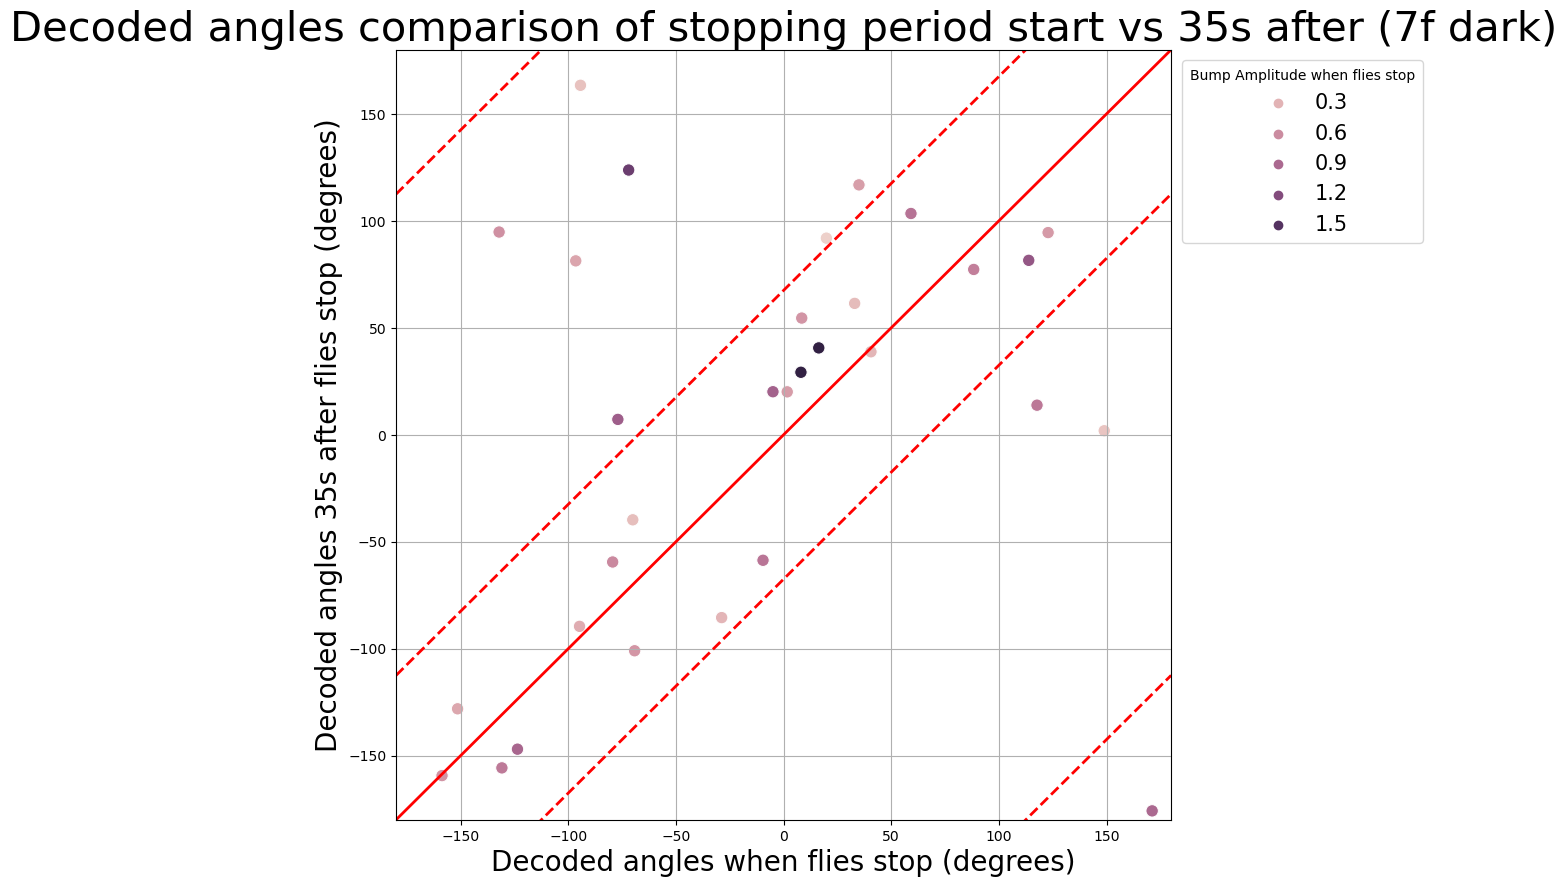

In [16]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_35s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Decoded angles comparison of stopping period start vs 35s after (7f dark)', fontsize =30)
plt.ylabel('Decoded angles 35s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()
#a.savefig('E-PG_Bump_Angle_35s_after_dark', format ='svg')

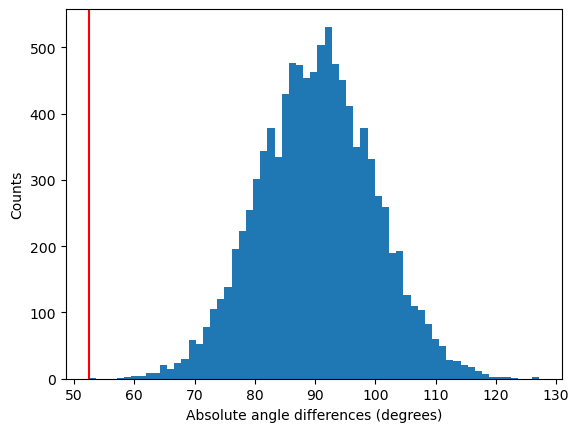

In [84]:
dark_stop_period_start_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)))
dark_stop_period_end_35s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(output_df_pooled['PVA_35s_after_stop'])==0)
for i in range(len(dark_stop_period_start_35s )):
    dark_stop_period_start_35s[i] = output_df_pooled['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_35s[i] =  output_df_pooled['PVA_35s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_35s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_35s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_35s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_35s ,dark_stop_period_end_35s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     
    
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()

In [85]:
actual_mean_absolute_angle_diff_dark     

52.449256606553796

In [97]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.0005)

52.66366712801736